## 评分矩阵构建

数据集：<http://www.grouplens.org/system/files/ml-100k.zip>，（u_id, movie_id, rating, timestamp）。

![](img/1.png)

从文件中读取评分记录，生成评分矩阵。

In [1]:
import numpy as np
from sklearn.feature_extraction import DictVectorizer
import math
import matplotlib.pyplot as plt
# Read in data
def loadData(filename,path="ml-100k/"):
    data = []
    y = []
    users=set()
    items=set()
    with open(path+filename) as f:
        for line in f:
            (user,movieid,rating,ts)=line.split('\t')
#             data.append({ "user_id": str(user), "movie_id": str(movieid)})
            data.append([int(user),int(movieid)])
            y.append(float(rating))
            users.add(user)
            items.add(movieid)

    return (np.array(data), np.array(y), users, items)

得到训练集以及测试集。

In [2]:
(train_data, y_train, train_users, train_items) = loadData("ua.base")
(test_data, y_test, test_users, test_items) = loadData("ua.test")
# train_data[:,1]
(num_user,num_mv) = np.amax(train_data, axis=0)
N = len(train_data)
# num_user, num_mv

aa_p   = train_data[:,0]-1;
aa_m   = train_data[:,1]-1;
rating = y_train;

## Gradient Decent

PMF（概率矩阵分解）
U - 用户隐式矩阵；V - 物品隐式矩阵
<br>
∆xt = -ηgt

得到损失函数
![](img/2.png)
对U、V求偏导，更新U、V
![](img/3.png)
![](img/4.png)
![](img/5.png)

根据求偏导结果更新用户和物品的隐式特征矩阵

In [3]:
num_features = 10
lamda_U = 0.1
lamda_V = 0.1
learning_rate = 0.00001

U = np.random.rand(num_user, num_features)
V = np.random.rand(num_mv, num_features)

iter_num = 200
loss_gd = []

for k in range(iter_num):
    predict_matrix = np.sum(U[aa_p,:]*V[aa_m,:], axis=1)
    IO = np.array([predict_matrix-rating]).T

    Ix_U = IO * V[aa_m,:] + lamda_U * U[aa_p,:]
    Ix_V = IO * U[aa_p,:] + lamda_V * V[aa_m,:]
    l = np.sum(np.square(IO)) + 1/2.0*lamda_U*np.sum(np.square(U)) + 1/2.0*lamda_V*np.sum(np.square(V))

    l = math.sqrt(l/N)
    
    loss_gd.append(l)
    
    print "Iter " , k  , "\t" + "loss: " , l
    du = np.zeros((num_user, num_features))
    dv = np.zeros((num_mv, num_features))
    for i in range(N):
        du[aa_p[i],:] = du[aa_p[i],:] + Ix_V[i,:]
        dv[aa_m[i],:] = dv[aa_m[i],:] + Ix_U[i,:]
    V = V - learning_rate*dv
    U = U - learning_rate*du

Iter  0 	loss:  1.66339325397
Iter  1 	loss:  1.65731494653
Iter  2 	loss:  1.651288612
Iter  3 	loss:  1.64531419151
Iter  4 	loss:  1.63939163102
Iter  5 	loss:  1.63352087962
Iter  6 	loss:  1.62770188808
Iter  7 	loss:  1.62193460742
Iter  8 	loss:  1.61621898776
Iter  9 	loss:  1.61055497717
Iter  10 	loss:  1.60494252071
Iter  11 	loss:  1.59938155955
Iter  12 	loss:  1.59387203017
Iter  13 	loss:  1.58841386369
Iter  14 	loss:  1.58300698524
Iter  15 	loss:  1.57765131343
Iter  16 	loss:  1.57234675983
Iter  17 	loss:  1.56709322865
Iter  18 	loss:  1.56189061629
Iter  19 	loss:  1.55673881112
Iter  20 	loss:  1.55163769319
Iter  21 	loss:  1.54658713402
Iter  22 	loss:  1.54158699648
Iter  23 	loss:  1.53663713464
Iter  24 	loss:  1.53173739367
Iter  25 	loss:  1.52688760984
Iter  26 	loss:  1.52208761043
Iter  27 	loss:  1.51733721382
Iter  28 	loss:  1.51263622945
Iter  29 	loss:  1.50798445791
Iter  30 	loss:  1.50338169103
Iter  31 	loss:  1.49882771195
Iter  32 	loss:  1.4

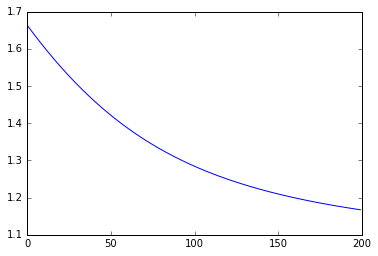

In [4]:
%matplotlib inline
plt.plot(loss_gd)

## Per Dimensional Solution
对于PMF而言，用户的隐式特征矩阵是一个多维矩阵，即拥有多个feature，每一个维度的下降速率不同，我们可以通过为每一维维护learning rate，达到优化Gradient Decent的目的。

###  Momentum

∆xt = ρ∆xt−1 − ηgt

In [5]:
num_features = 10
lamda_U = 0.1
lamda_V = 0.1
learning_rate = 0.00001
momentum = 0.9

U = np.random.rand(num_user, num_features)
V = np.random.rand(num_mv, num_features)

iter_num = 200
loss_mom = []

du_ = np.zeros((num_user, num_features))
dv_ = np.zeros((num_mv, num_features))

for k in range(iter_num):
    predict_matrix = np.sum(U[aa_p,:]*V[aa_m,:], axis=1)
    IO = np.array([predict_matrix-rating]).T

    Ix_U = IO * V[aa_m,:] + lamda_U * U[aa_p,:]
    Ix_V = IO * U[aa_p,:] + lamda_V * V[aa_m,:]
    l = np.sum(np.square(IO)) + 1/2.0*lamda_U*np.sum(np.square(U)) + 1/2.0*lamda_V*np.sum(np.square(V))

    l = math.sqrt(l/N)
    
    loss_mom.append(l)
    
    print "Iter " , k  , "\t" + "loss: " , l
    du = np.zeros((num_user, num_features))
    dv = np.zeros((num_mv, num_features))
    for i in range(N):
        du[aa_p[i],:] = du[aa_p[i],:] + Ix_V[i,:]
        dv[aa_m[i],:] = dv[aa_m[i],:] + Ix_U[i,:]
        
    dv = momentum * dv_ - learning_rate*dv
    du = momentum * du_ - learning_rate*du
    V = V + dv
    U = U + du
    
    dv_ = dv
    du_ = du

Iter  0 	loss:  1.67642857824
Iter  1 	loss:  1.67033428723
Iter  2 	loss:  1.65883157543
Iter  3 	loss:  1.64260584004
Iter  4 	loss:  1.62233740357
Iter  5 	loss:  1.59869968365
Iter  6 	loss:  1.57235817532
Iter  7 	loss:  1.54396889247
Iter  8 	loss:  1.51417531891
Iter  9 	loss:  1.48360323182
Iter  10 	loss:  1.45285305475
Iter  11 	loss:  1.42248972541
Iter  12 	loss:  1.39303044675
Iter  13 	loss:  1.36493112186
Iter  14 	loss:  1.33857270486
Iter  15 	loss:  1.31424904822
Iter  16 	loss:  1.29215798368
Iter  17 	loss:  1.27239724241
Iter  18 	loss:  1.25496635541
Iter  19 	loss:  1.23977492125
Iter  20 	loss:  1.22665672398
Iter  21 	loss:  1.21538832868
Iter  22 	loss:  1.20571017108
Iter  23 	loss:  1.19734791848
Iter  24 	loss:  1.19003202917
Iter  25 	loss:  1.18351389955
Iter  26 	loss:  1.17757762175
Iter  27 	loss:  1.17204703373
Iter  28 	loss:  1.16678831308
Iter  29 	loss:  1.16170877818
Iter  30 	loss:  1.15675279681
Iter  31 	loss:  1.15189577927
Iter  32 	loss:  1

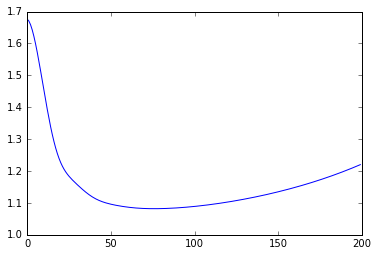

In [6]:
plt.plot(loss_mom)

### Adagrad

![](img/6.png)

In [7]:
num_features = 10
lamda_U = 0.1
lamda_V = 0.1
learning_rate = 0.01

U = np.random.rand(num_user, num_features)
V = np.random.rand(num_mv, num_features)

iter_num = 200
loss_ada = []

grad_u_sum = np.zeros((num_user, num_features)) + 0.0001
grad_v_sum = np.zeros((num_mv, num_features)) + 0.0001

for k in range(iter_num):
    predict_matrix = np.sum(U[aa_p,:]*V[aa_m,:], axis=1)
    IO = np.array([predict_matrix-rating]).T

    Ix_U = IO * V[aa_m,:] + lamda_U * U[aa_p,:]
    Ix_V = IO * U[aa_p,:] + lamda_V * V[aa_m,:]
    l = np.sum(np.square(IO)) + 1/2.0*lamda_U*np.sum(np.square(U)) + 1/2.0*lamda_V*np.sum(np.square(V))

    l = math.sqrt(l/N)
    
    loss_ada.append(l)
    
    print "Iter " , k  , "\t" + "loss: " , l
    du = np.zeros((num_user, num_features))
    dv = np.zeros((num_mv, num_features))
    for i in range(N):
        du[aa_p[i],:] = du[aa_p[i],:] + Ix_V[i,:]
        dv[aa_m[i],:] = dv[aa_m[i],:] + Ix_U[i,:]
    
    grad_u_sum += np.square(du)
    grad_v_sum += np.square(dv)
    
    dv = -1.0 / np.sqrt(grad_v_sum) * learning_rate*dv
    du = -1.0 / np.sqrt(grad_u_sum) * learning_rate*du
    V = V + dv
    U = U + du

Iter  0 	loss:  1.66923775912
Iter  1 	loss:  1.61555208123
Iter  2 	loss:  1.57950581914
Iter  3 	loss:  1.55109060694
Iter  4 	loss:  1.52719763801
Iter  5 	loss:  1.50639202868
Iter  6 	loss:  1.48786631155
Iter  7 	loss:  1.47111428009
Iter  8 	loss:  1.45579023782
Iter  9 	loss:  1.44164916638
Iter  10 	loss:  1.42850884252
Iter  11 	loss:  1.41623010291
Iter  12 	loss:  1.40470319109
Iter  13 	loss:  1.3938397716
Iter  14 	loss:  1.38356739368
Iter  15 	loss:  1.37382577051
Iter  16 	loss:  1.36456407734
Iter  17 	loss:  1.35573899342
Iter  18 	loss:  1.34731325112
Iter  19 	loss:  1.33925452768
Iter  20 	loss:  1.33153457544
Iter  21 	loss:  1.32412853181
Iter  22 	loss:  1.31701436921
Iter  23 	loss:  1.31017245495
Iter  24 	loss:  1.30358519713
Iter  25 	loss:  1.29723675753
Iter  26 	loss:  1.29111281624
Iter  27 	loss:  1.28520037631
Iter  28 	loss:  1.27948759971
Iter  29 	loss:  1.27396366838
Iter  30 	loss:  1.26861866578
Iter  31 	loss:  1.2634434753
Iter  32 	loss:  1.2

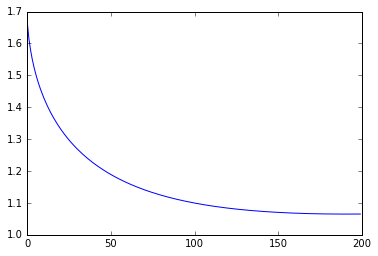

In [8]:
plt.plot(loss_ada)

## Comparison

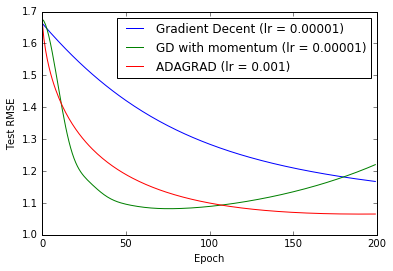

In [16]:
plt.plot(loss_gd)
plt.plot(loss_mom)
plt.plot(loss_ada)
plt.xlabel('Epoch')
plt.ylabel('Test RMSE')
plt.legend(['Gradient Decent (lr = 0.00001)', 'GD with momentum (lr = 0.00001)', 'ADAGRAD (lr = 0.001)'], loc='upper right')
plt.show()

* 对于单纯的GD，所有的维度都使用一个全局的固定的学习速率，学习速率太大，会找不到局部最优值；而学习速率过小，又会使得收敛速度过慢；
* 增加了momentum后，在更新时保留原有的下降方向，使得每一维的学习速率都是动态调整的，加快了收敛速度，提高了收敛的稳定性；
* AdaGrad算法会自适应地为各个参数分配不同学习速率，对于每个参数，随着其更新的总距离增多，其学习速率也随之变慢。但是AdaGrad的学习速率是不断递减的，如果初始的学习速率选取的非常小的话，会造成收敛速度非常缓慢。